In [1]:
# Install packages
!apt-get update
!apt-get install -y swig
!sudo apt-get update
!sudo apt-get install xvfb
!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [973 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,591 kB]
Get:13 http://archive.ub

In [2]:
import gym
import io
import os
import glob
import torch
import base64
import numpy as np
import copy
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from gym.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
# Creat envoiroment
env = gym.make("LunarLander-v2", new_step_api=True)

env.reset()

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Introduction to state and action space
print(f'size state space : {state_size}')
print(f'size of action space: {action_size}')

print(f'Sample state space: {env.observation_space.sample()}')
print(f'Sample action space: {env.action_space.sample()}')

size state space : 8
size of action space: 4
Sample state space: [ 0.82423574  0.17583738 -4.7158504   4.6131063  -2.3343933   1.7261866
  0.11316744  0.72727317]
Sample action space: 3


In [5]:
# Set up virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# Utility function to enable video recording of gym environment and displaying it
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [6]:
# Set random seed
SEED = 14
random.seed(SEED)
torch.manual_seed(SEED)

# **PART 2**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
# Experience replay
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)

    def store_trans(self, s, a, sp, r, done):
        transition = Transition(s, a, sp, r, done)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
# Deep Q-Network Structure

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        net_list = nn.ModuleList([
            torch.nn.Linear(state_size, 512),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, action_size)
        ])
        self.net = torch.nn.Sequential(*net_list).to(device)

    def forward(self, x):
        x = x.to(device)
        x = self.net(x)
        return x

In [10]:
# DQN agent

class DQNAgent():
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.experience_replay = ExperienceReplay(buffer_size)
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        self.value_net.eval()
        if random.random() > eps:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                action_values = self.value_net(state_tensor)
                return torch.argmax(action_values).item()
        else:
            return np.random.randint(0, self.action_size)

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))
        state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
        action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
        next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

        self.value_net.train()
        q_expected = self.value_net(state_batch).gather(1, action_batch)
        q_targets_next = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        q_targets = reward_batch + (self.gamma * q_targets_next * (1 - done_batch))
        loss = nn.functional.mse_loss(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, fname):
        torch.save(self.value_net.state_dict(), fname)

    def load(self, fname, device):
        self.value_net.load_state_dict(torch.load(fname, map_location=device))

In [11]:
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 128

In [12]:


# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
#         print(action)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

Episode 1	Average Reward: -36.60	Epsilon: 0.97

<ipython-input-10-974abc04076d>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)


Episode 25	Average Reward: -81.32	Epsilon: 0.47
Episode 49	Average Reward: -39.20	Epsilon: 0.22

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain back

Episode 50	Average Reward: -32.71	Epsilon: 0.22


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 75	Average Reward: 163.31	Epsilon: 0.10
Episode 99	Average Reward: 220.30	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 100	Average Reward: 221.35	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 183.60	Epsilon: 0.02
Episode 149	Average Reward: 231.04	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 150	Average Reward: 232.40	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 175	Average Reward: 211.58	Epsilon: 0.01
Episode 199	Average Reward: 224.55	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 200	Average Reward: 232.95	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 245.87	Epsilon: 0.01
Episode 249	Average Reward: 196.51	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 250	Average Reward: 197.24	Epsilon: 0.01


<Figure size 640x480 with 0 Axes>

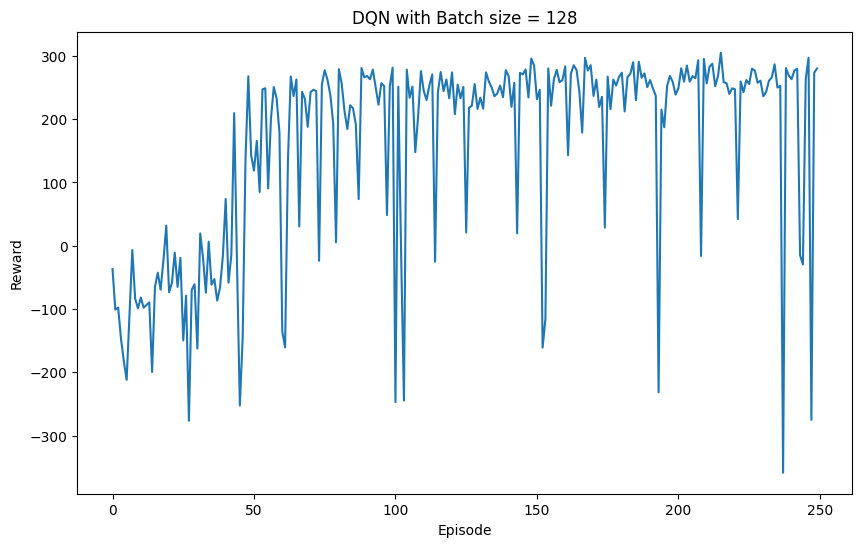

In [13]:
# Plot cumulative reward of each episode
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN with Batch size = {BATCH_SIZE}")
plt.show()

# **part 3**

In [14]:
# Double DQN Agent

class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_buffer = ExperienceReplay(buffer_size)

        # networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        # NOTE: target network parameters DOSEN'T update with optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE:
        self.value_net.eval()
        rand_eps = random.random()
        if rand_eps > eps:
            with torch.no_grad():
                return torch.argmax(self.value_net(torch.tensor(state).to(device))).detach().cpu().numpy()
        else:
            return np.random.randint(0, self.action_size)

    def update_params(self):
        if len(self.experience_buffer) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.experience_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()
        # STEP1
        q_targets_next = self.target_value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        q_targets = reward_batch + self.gamma * q_targets_next * (1 - done_batch*1)
        q_expected = self.value_net(state_batch).gather(1, action_batch)
        # STEP3
        # TODO: compute mse loss
        loss = nn.functional.mse_loss(q_expected, q_targets)
        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        # TODO: copy main network parameters to target network parameters
        self.target_value_net = copy.deepcopy(self.value_net)

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.value_net, fname)

    def load(self, fname, device):
        # TODO: load checkpoint
        self.value_net = torch.load(fname, device)

In [21]:
# Set training parameters
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 32

In [22]:
# Training phase

# TODO: create agent
agent = DDQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    action_count = 0
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_buffer.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        action_count += 1
        if action_count % 5 == 0:
            agent.update_target_network()

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DDQN/DDQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 25	Average Reward: -171.03	Epsilon: 0.47
Episode 49	Average Reward: 10.72	Epsilon: 0.22

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 50	Average Reward: 21.79	Epsilon: 0.22


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 75	Average Reward: 28.20	Epsilon: 0.10
Episode 99	Average Reward: 136.43	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 100	Average Reward: 137.72	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 180.28	Epsilon: 0.02
Episode 149	Average Reward: 175.27	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 150	Average Reward: 189.58	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 175	Average Reward: 244.30	Epsilon: 0.01
Episode 199	Average Reward: 167.45	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 200	Average Reward: 165.24	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 213.94	Epsilon: 0.01
Episode 249	Average Reward: 221.24	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 250	Average Reward: 216.40	Epsilon: 0.01


<Figure size 640x480 with 0 Axes>

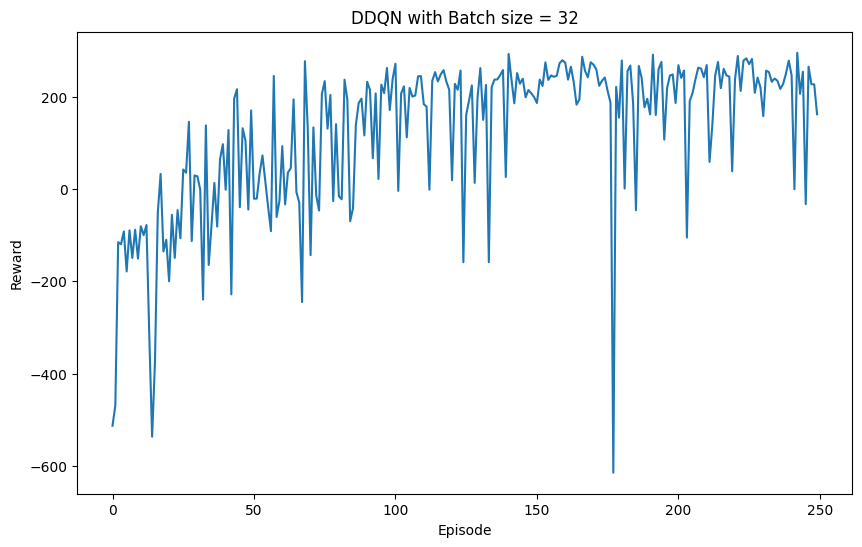

In [23]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DDQN with Batch size = {BATCH_SIZE}")
plt.show()